<a href="https://colab.research.google.com/github/z-gard/analysis/blob/main/notebooks/environment_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 周辺環境スコア
- input
    - park_score.csv
        - 公園スコア
    - sports_score.csv
        - 運動場スコア
        - 体育館スコア
        - プールスコア
- output
    - environment_score.csv
        - 周辺環境スコア


In [1]:
!pip install -q japanize-matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [4]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse, quote
import io
import math
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [5]:
score_name = '周辺環境スコア'
output_score_file = 'environment_score.csv'

### 人口マスタ

In [6]:
df_pop_master = pd.read_csv(os.path.join(DIR_NAME, 'population_master.csv'))[[
    '地域ID', '市区町村名', '町名', '町丁目'
]].set_index('地域ID')
print(df_pop_master.shape)

(3145, 3)


### 公園スコア

In [7]:
df_park_score = pd.read_csv(os.path.join(DIR_NAME, 'park_score.csv'))[[
    '地域ID',
    '_公園スコア', '公園スコア',
]].set_index('地域ID')
print(df_park_score.shape)

(1750, 2)


In [8]:
df_park_score.head()

,_公園スコア,公園スコア
地域ID,,
102002,0.357888,0.751335
102004,0.432958,1.016590
102005,0.446570,1.076659
102006,0.434280,1.030892
102008,0.351159,0.736079


### スポーツ施設

In [9]:
df_sports_score = pd.read_csv(os.path.join(DIR_NAME, 'sports_score.csv'))[[
    '地域ID', 
    '_運動場スコア', '運動場スコア',
    '_体育館スコア', '体育館スコア',
    '_プールスコア', 'プールスコア',
]].set_index('地域ID')
print(df_sports_score.shape)

(1839, 6)


In [10]:
df_sports_score.head()

,_運動場スコア,運動場スコア,_体育館スコア,体育館スコア,_プールスコア,プールスコア
地域ID,,,,,,
103003,0.520414,2.851116,0.172060,0.370169,0.836179,4.764108
103004,0.542352,3.176783,0.186288,0.431864,0.912104,4.905643
103005,0.542859,3.187670,0.198171,0.457267,0.852995,4.804028
103006,0.560951,3.468019,0.218121,0.515333,0.882224,4.862094
103007,0.550070,3.312874,0.251664,0.635093,0.828470,4.724188


In [11]:
def normalize_score(sr_data, high=True, outlier=True):
    score = (sr_data - sr_data.mean())/sr_data.std()
    score = score if high else -score

    if outlier:
        high_s = score.quantile(0.99)
        low_s = score.quantile(0.01)
        score[score > high_s] = high_s
        score[score < low_s] = low_s
    else:
        high_s = score.max()
        low_s = score.min()
        
    return (score - low_s)/(high_s - low_s)


def rank_score(sr_data):
    size = sr_data.notna().sum()
    rank = sr_data.rank()
    result = rank.copy()
    # 0~1: 15%, 1~2: 20%, 2~3: 30%, 3~4: 20%, 4~5: 15%
    level_list = [0.15, (0.15+0.2), (0.15+0.2+0.3), (0.15+0.2+0.3+0.2), 1]
    
    pre_level = 0
    for index, level in enumerate([lv*size for lv in level_list]):
        result[(rank > pre_level)&(rank <= level)] = (rank - pre_level)/(level - pre_level) + index
        pre_level = level

    return result

### 周辺環境スコア

In [12]:
df_score = pd.concat([
    df_pop_master,
    df_park_score,
    df_sports_score
], axis=1)
print(df_score.shape)
assert len(df_score) == len(df_pop_master)

(3145, 11)


In [13]:
print(df_score.shape)
df_score.head()

(3145, 11)


,市区町村名,町名,町丁目,_公園スコア,公園スコア,_運動場スコア,運動場スコア,_体育館スコア,体育館スコア,_プールスコア,プールスコア
地域ID,,,,,,,,,,,
101003,千代田区,丸の内,丸の内１丁目,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101004,千代田区,丸の内,丸の内２丁目,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101005,千代田区,丸の内,丸の内３丁目,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101007,千代田区,大手町,大手町１丁目,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101008,千代田区,大手町,大手町２丁目,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
feature_list = {
    '_公園スコア': {'high': True, 'outlier': False, 'weight': 1}, 
    '_運動場スコア': {'high': True, 'outlier': False, 'weight': 0.3}, 
    '_体育館スコア': {'high': True, 'outlier': False, 'weight': 0.3}, 
    '_プールスコア': {'high': True, 'outlier': False, 'weight': 0.3},
}

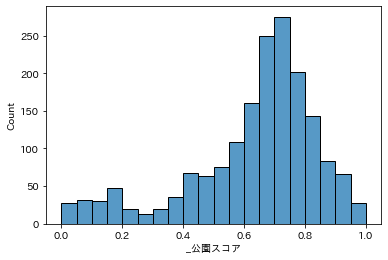

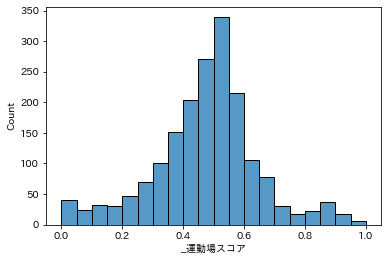

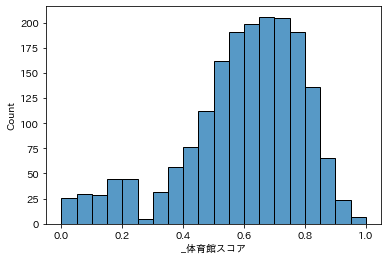

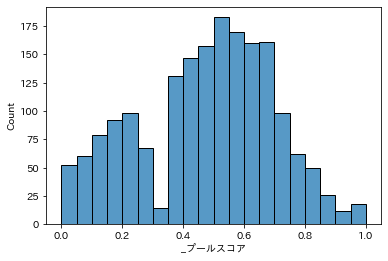

In [15]:
for feature_name in feature_list.keys():
    sns.histplot(df_score[feature_name], bins=20)
    plt.show()

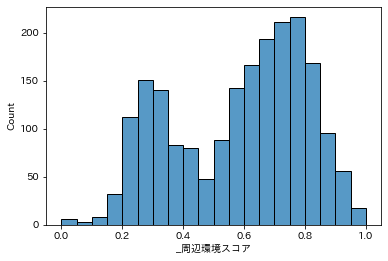

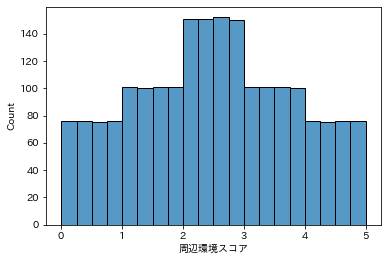

In [16]:
score_list = []
for key, value in feature_list.items():
    score_list.append(df_score[key] * value['weight'])

score_sub_name = '_' + score_name
sum_score = pd.concat(score_list, axis=1).dropna(how='all').sum(axis=1)
df_score[score_sub_name] = normalize_score(sum_score, outlier=False)
df_score[score_name] = rank_score(df_score[score_sub_name])

total_score_list = [score_sub_name, score_name]
for _score in total_score_list:
    sns.histplot(df_score[_score], bins=20)
    plt.show()

In [17]:
df_score[
    ['市区町村名', '町丁目'] + list(feature_list.keys()) + total_score_list
].to_csv(os.path.join(DIR_NAME, output_score_file), index=True)

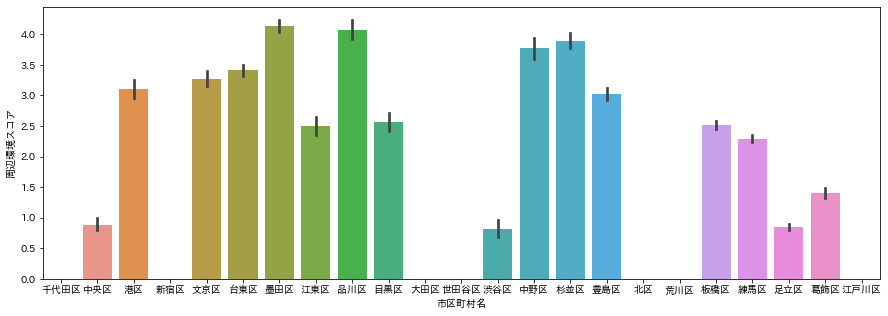

In [18]:
plt.figure(figsize=(15, 5))
sns.barplot(x='市区町村名', y=score_name, data=df_score)
plt.show()

In [19]:
df_level = df_score.copy()
df_level['rank'] = df_level.groupby('町名')[score_name].transform('rank', ascending=False)
df_level = df_level[df_level['rank'] == 1].sort_values(score_name, ascending=False)[
    ['市区町村名', '町名', '町丁目'] + total_score_list + list(feature_list.keys())
].reset_index(drop=True)
print(df_level.shape)

(561, 9)


In [20]:
df_level.head(20)

,市区町村名,町名,町丁目,_周辺環境スコア,周辺環境スコア,_公園スコア,_運動場スコア,_体育館スコア,_プールスコア
0,品川区,豊町,豊町１丁目,1.000000,5.000000,0.961622,0.540078,0.800265,0.766144
1,品川区,戸越,戸越２丁目,0.984430,4.996693,0.964586,0.497828,0.799248,0.721640
2,杉並区,高円寺南,高円寺南１丁目,0.977592,4.993386,0.968110,0.596787,0.720165,0.655811
3,品川区,東中延,東中延１丁目,0.977193,4.990079,0.988299,0.436205,0.772487,0.694777
4,墨田区,東向島,東向島４丁目,0.969893,4.983466,0.987048,0.893568,0.499312,0.478238
5,品川区,平塚,平塚３丁目,0.967902,4.980159,0.982273,0.371531,0.805936,0.699608
6,品川区,荏原,荏原１丁目,0.958091,4.963624,0.936786,0.368975,0.779655,0.830986
7,品川区,西中延,西中延１丁目,0.955959,4.960317,0.964331,0.346070,0.791834,0.739229
8,中野区,中央,中央５丁目,0.954332,4.953704,0.999867,0.541178,0.595435,0.613927
9,品川区,北品川,北品川２丁目,0.952196,4.950397,0.978417,0.577151,0.544157,0.690049


In [21]:
df_level.tail(20)

,市区町村名,町名,町丁目,_周辺環境スコア,周辺環境スコア,_公園スコア,_運動場スコア,_体育館スコア,_プールスコア
541,足立区,椿,椿２丁目,0.229353,0.350529,NaN,0.504175,0.792201,0.160256
542,足立区,堀之内,堀之内２丁目,0.228299,0.333995,NaN,0.513622,0.813309,0.124430
543,中央区,日本橋大伝馬町,日本橋大伝馬町,0.224523,0.310847,0.429740,NaN,NaN,NaN
544,渋谷区,神南,神南２丁目,0.222950,0.297619,0.427379,NaN,NaN,NaN
545,渋谷区,道玄坂,道玄坂１丁目,0.219930,0.271164,0.422848,NaN,NaN,NaN
546,葛飾区,新小岩,新小岩１丁目,0.218337,0.257937,0.061477,0.464174,0.461404,0.271021
547,足立区,舎人,舎人１丁目,0.214260,0.231481,NaN,0.475228,0.500383,0.405516
548,渋谷区,松涛,松涛２丁目,0.212609,0.211640,0.411860,NaN,NaN,NaN
549,渋谷区,宇田川町,宇田川町,0.207322,0.195106,0.403925,NaN,NaN,NaN
550,中央区,八重洲１丁目,八重洲１丁目,0.204218,0.178571,0.399267,NaN,NaN,NaN
